### 데이콘 비트코인 가격 예측 - ARIMA

In [3]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import IPython, IPython.display

# model library
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

# self-library
import preprocessor, simulator

In [4]:

# modeling programing
def auto_arima_modeling(input_array):
    ''' 함수 설명 : auto arima fitting & prediction'''
    
    #미래 데이터 저장을 위한 빈 array 생성
    valid_pred_array =  np.zeros([input_array.shape[0], 120])
    zero_para_counter = 0
    
    #모델 돌리기 및 결과 저장
    for idx in tqdm(range(input_array.shape[0])):
        try:
            x_series = input_array[idx,:].reshape(-1)
            
            # arima 파라미터 최적화
            optim_pararmeter = auto_arima(x_series, stepwise=True, error_action='ignore', seasonal=False)
            model = ARIMA(x_series, order=optim_pararmeter.order)
            
            # 모델 학습
            fit = model.fit()
            preds = fit.predict(1, 120, typ='levels')
            print(preds)
            valid_pred_array[idx,:] = preds # - (preds[0]-x_series[-1])
        
        except:
            zero_para_counter += 1
            print(
                f'{idx}번째 샘플은 수렴하지 않습니다. \nARIMA 파라미터 (p,d,q) 값을 모두 0으로 설정합니다.'
            )
            # ARIMA의 (p,d,q) 값이 (5,1,1), (4,1,1)에서 수렴하지 않을 경우
            # 모두 0으로 채움
            pass
        
        # clear display
        IPython.display.clear_output()
    
    print(f'''
    Warning : {len(input_array)}의 샘플 내 {zero_para_counter}개의 샘플이 수렴하지 못 했습니다.
    '''
    )
    return valid_pred_array

In [4]:
### ------------ Data upload part ---------------- ###

# 데이터가 위치한 폴더 경로
dir_path = './data'

# 파일명 설정
x_file_name, y_file_name = 'train_x_df.csv', 'train_y_df.csv'
x_file_path = os.path.join(dir_path, x_file_name)
y_file_path = os.path.join(dir_path, y_file_name)

#파일 업로드
train_x_df = pd.read_csv(x_file_path)
train_y_df = pd.read_csv(y_file_path)
print("Reading Complete!")

Reading Complete!


In [5]:
### --------------- Modeling part ---------------- ###

# 데이터 전처리 1 : dafaframe to array 
train_x_array = preprocessor.df2d_to_array3d(train_x_df)
train_y_array = preprocessor.df2d_to_array3d(train_y_df)

# 데이터 전처리 2 : 실수 차분(Fractional Differencing) -> diff_train_open_array 
FFD_train_x_array = preprocessor.FFD_smoothing(train_x_array)

# 데이터 전처리 2-2 : 비차분
# normal_x_array = train_x_array[:383, :, 1].reshape(383, 1380, 1) # open col is 1

In [ ]:
# modeling start and save predicted array
valid_pred_array = auto_arima_modeling(input_array=FFD_train_x_array)
save_file_name = 'arima_result.csv'
np.savetxt(save_file_name, valid_pred_array, delimiter = ",")


In [13]:
pred_array = pd.read_csv('./results/FFD_neural_prophet_result.csv', header=None)
pred_arr = pred_array.values

In [22]:
#구매량 및 판매 시점
valid_submission = simulator.array_to_submission(pred_arr, start_idx=0, increase_rate = 1.04)

#투자 시뮬레이션 vali sample is < 383
valid_y_df = train_y_df[train_y_df.sample_id < 383]

In [26]:
valid_arr = simulator.df2d_to_answer(valid_y_df)
total_momey, total_momey_list = simulator.COIN(valid_arr, valid_submission)

In [30]:

exp_name = 'Auto ARIMA with FracDiff'

In [39]:
def investing_histroy(exp_name, total_momey_list, total_momey, save_mode):
    

    # 투자 히스토리
    plt.plot(total_momey_list)
    plt.title(exp_name + " Investing History", fontsize = 12, y = 1.02)
    plt.ylabel("total asset")
    plt.xlabel("trial time")
    plt.text(60, 10000, total_momey)
    plt.grid(True)

    if save_mode is True:
        plt.savefig(f'./images/{exp_name}.png')
    plt.show()

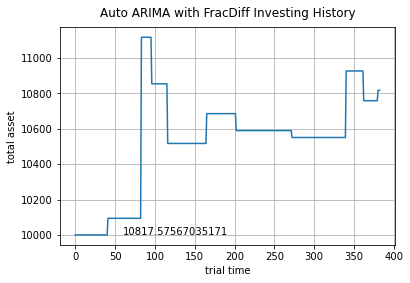

In [40]:
investing_histroy(exp_name, total_momey_list, total_momey, save_mode = False)